# Forecasting Simple Time-Series

This example shows how to estimate time-series that are relatively constant or have a defined trend, but other than that do not have any patterns over time. If there are other patterns in the data, such as seasonality, see Forecasting Complex Time-Series.

## Load in the Data

We'll load in the data with `pandas`, which should be review.

In [1]:
import pandas as pd
df = pd.read_excel('Sales COGS.xlsx')

In [2]:
df.head()

,Unnamed: 0,2017-12-31 00:00:00,2018-12-31 00:00:00,2019-12-31 00:00:00
0,Sales,1000,1200,1100
1,Cost of Goods Sold,620,700,650


Here we should use Sales, Cost of Goods sold as the index. Load in by setting the index column.

In [3]:
df = pd.read_excel('Sales COGS.xlsx', index_col=0)
df.head()

,2017-12-31,2018-12-31,2019-12-31
Sales,1000,1200,1100
Cost of Goods Sold,620,700,650


Now that looks better.

## Plot Data

For an effective plot, we will need to transpose the data, so that the dates are the index (x-axis on plot), and the data types are columns (series on plot). Thankfully this is as simple as `df.T`.

In [37]:
df.T

,Sales,Cost of Goods Sold
2017-12-31,1000,620
2018-12-31,1200,700
2019-12-31,1100,650


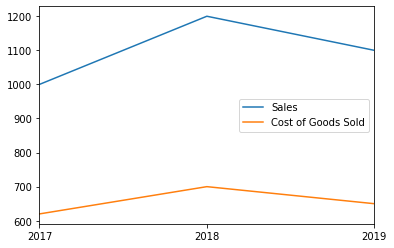

In [35]:
%matplotlib inline

df.T.plot.line()

## Forecast Using Most Recent Value

This is the simplest forecast, just keep it the same as it was. 

Right now we have the dates as the columns. So access the columns and take the max to find the latest date.

In [7]:
last_date = df.columns.max()
last_date

Timestamp('2019-12-31 00:00:00')

Now select the values which have the latest date as the forecast

In [10]:
fcst_sales = df.loc['Sales'][last_date]
fcst_cogs = df.loc['Cost of Goods Sold'][last_date]
print(f'The forecasted value for sales is ${fcst_sales:,.0f} and for COGS is ${fcst_cogs:,.0f}')

The forecasted value for sales is $1,100 and for COGS is $650


## Forecast Using Average

We have already seen how to take averages of `pandas` `Series`:

In [11]:
fcst_sales = df.loc['Sales'].mean()
fcst_cogs = df.loc['Cost of Goods Sold'].mean()
print(f'The forecasted value for sales is ${fcst_sales:,.0f} and for COGS is ${fcst_cogs:,.0f}')

The forecasted value for sales is $1,100 and for COGS is $657


## Forecast Using Trend

There are two methods to forecast using the trend.

### Trend Method 1: By Regression

We will estimate the following regression model:
$$y_t = a + \beta t + \epsilon_t$$

#### Create DataFrame with $t$

First we need to create a `DataFrame` which has a column for the $y$ and a column for the $t$:.

To do this, first we can create a `DataFrame` from the `Series` we want to forecast.

In [14]:
for_fcst_df = pd.DataFrame(df.loc['Sales'])
for_fcst_df

,Sales
2017-12-31,1000
2018-12-31,1200
2019-12-31,1100


We can use `reset_index(drop=True)` to get rid of the date index.

In [15]:
for_fcst_df = for_fcst_df.reset_index(drop=True)
for_fcst_df

,Sales
0,1000
1,1200
2,1100


We can now use `reset_index()` without the `drop=True` to get this new 0, 1, 2 index as a column.

In [16]:
for_fcst_df = for_fcst_df.reset_index()
for_fcst_df

,index,Sales
0,0,1000
1,1,1200
2,2,1100


We can also rename that column.

In [17]:
for_fcst_df = for_fcst_df.rename(columns={'index': 't'})
for_fcst_df

,t,Sales
0,0,1000
1,1,1200
2,2,1100


Let's wrap this all up in a function as we'll need to use this for COGS as well, and for the CAGR approaches.

In [19]:
def for_forecast_df_from_orig_df(orig_df, series_name):
    """
    From a DataFrame where index is name of series to be forecasted and columns are time periods, create a 
    DataFrame with two columns, t in periods and the value to be forecasted, and rows are time periods.
    """
    for_fcst_df = pd.DataFrame(orig_df.loc[series_name])
    for_fcst_df = for_fcst_df.reset_index(drop=True).reset_index()
    for_fcst_df = for_fcst_df.rename(columns={'index': 't'})
    return for_fcst_df

for_forecast_df_from_orig_df(df, 'Cost of Goods Sold')

,t,Cost of Goods Sold
0,0,620
1,1,700
2,2,650


#### Now Run Regression

This should be review from the cost of equity exercise.

In [24]:
import statsmodels.api as sm

model = sm.OLS(for_fcst_df['Sales'], sm.add_constant(for_fcst_df['t']), hasconst=True)
results = model.fit()
results.summary()

c:\users\admin\.virtualenvs\fin-model-course-gvj3lsuv\lib\site-packages\statsmodels\stats\stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                 -0.500
Method:                 Least Squares   F-statistic:                    0.3333
Date:                Tue, 19 Nov 2019   Prob (F-statistic):              0.667
Time:                        12:47:39   Log-Likelihood:                -17.033
No. Observations:                   3   AIC:                             38.07
Df Residuals:                       1   BIC:                             36.26
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1050.0000    111.803      9.391      0.068    -370.597    2470.597
t             50.0000     86.603      0.577      0.667   -1050.390    1150.390
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   3.000
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.531
Skew:                           0.707   Prob(JB):                        0.767
Kurtosis:                       1.500   Cond. No.                         2.92
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now get the intercept and $\beta$ from the regression results.

In [26]:
intercept = results.params['const']
beta = results.params['t']

In [27]:
intercept

1050.0

In [28]:
beta

49.99999999999982

#### Now Predict from Regression Results

In [29]:
fcst_sales = intercept + beta * 3
fcst_sales

1199.9999999999995

Now let's wrap up the regression approach into a function to use it with COGS as well.

In [33]:
def intercept_and_t_beta_from_for_forecast_df(for_fcst_df, series_name):
    """
    Calculates intercept and beta of time periods from DataFrame set up for forecasting
    """
    model = sm.OLS(for_fcst_df[series_name], sm.add_constant(for_fcst_df['t']), hasconst=True)
    results = model.fit()
    intercept = results.params['const']
    beta = results.params['t']
    return intercept, beta

def predict_from_intercept_beta_and_t(intercept, beta, t):
    """
    Predicts value in period t based off regression intercept and beta
    """
    return intercept + beta * t

intercept, beta = intercept_and_t_beta_from_for_forecast_df(for_fcst_df, 'Sales')
fcst_sales = predict_from_intercept_beta_and_t(intercept, beta, 3)
fcst_sales

1199.9999999999995

#### Entire Approach for COGS Using Functions

Let's write one more function to do the entire forecast, putting everything together.

In [39]:
def forecast_trend_reg(df, series_name, t):
    """
    Full workflow of forecasting trend via regression
    """
    for_fcst_df = for_forecast_df_from_orig_df(df, series_name)
    intercept, beta = intercept_and_t_beta_from_for_forecast_df(for_fcst_df, series_name)
    fcst = predict_from_intercept_beta_and_t(intercept, beta, t)
    return fcst

fcst_sales = forecast_trend_reg(df, 'Sales', 3)
fcst_cogs = forecast_trend_reg(df, 'Cost of Goods Sold', 3)
print(f'The forecasted value for sales is ${fcst_sales:,.0f} and for COGS is ${fcst_cogs:,.0f}')

The forecasted value for sales is $1,200 and for COGS is $687


### Trend Method 2: By CAGR

Let's work off the `DataFrame` set up for forecasting from the regression approach.

In [40]:
for_fcst_df = for_forecast_df_from_orig_df(df, 'Sales')
for_fcst_df

,t,Sales
0,0,1000
1,1,1200
2,2,1100


We want to calculate $$\frac{y_T}{y_0}^{\frac{1}{n}} - 1$$

We can use `.iloc` (integer location) to get the first and last values of sales.

In [41]:
y_0 = for_fcst_df['Sales'].iloc[0]
y_0

1000

In [42]:
y_T = for_fcst_df['Sales'].iloc[-1]
y_T

1100

We can get the number of time periods elapsed in a similar way.

In [43]:
n = for_fcst_df['t'].iloc[-1] - for_fcst_df['t'].iloc[0]
n

2

Now just calculate

In [44]:
cagr = (y_T / y_0)**(1 / n) - 1
cagr

0.04880884817015163

Now to get the predicted value for period 3

Let's wrap this up into functions.

In [47]:
def cagr_from_for_forecast_df(for_fcst_df, series_name):
    """
    Calculates CAGR from DataFrame set up for forecasting
    """
    y_0 = for_fcst_df[series_name].iloc[0]
    y_T = for_fcst_df[series_name].iloc[-1]
    n = for_fcst_df['t'].iloc[-1] - for_fcst_df['t'].iloc[0]
    cagr = (y_T / y_0)**(1 / n) - 1
    return cagr


def predict_from_for_forecast_df_and_cagr(for_fcst_df, series_name, cagr, t):
    """
    Forecast value from DataFrame set up for forecasting and calculated CAGR
    """
    y_T = for_fcst_df[series_name].iloc[-1]
    n = for_fcst_df['t'].iloc[-1] - for_fcst_df['t'].iloc[0]
    
    future_nper = t - n
    fcst = y_T * (1 + cagr)**future_nper
    return fcst


cagr = cagr_from_for_forecast_df(for_fcst_df, 'Sales')
fcst_sales = predict_from_for_forecast_df_and_cagr(for_fcst_df, 'Sales', cagr, 3)
fcst_sales

1153.6897329871667

Now let's put the entire approach in one function.

In [48]:
def forecast_trend_cagr(df, series_name, t):
    """
    Full workflow of forecasting trend via CAGR
    """
    for_fcst_df = for_forecast_df_from_orig_df(df, series_name)
    cagr = cagr_from_for_forecast_df(for_fcst_df, series_name)
    fcst = predict_from_for_forecast_df_and_cagr(for_fcst_df, series_name, cagr, t)
    return fcst

fcst_sales = forecast_trend_cagr(df, 'Sales', 3)
fcst_cogs = forecast_trend_cagr(df, 'Cost of Goods Sold', 3)
print(f'The forecasted value for sales is ${fcst_sales:,.0f} and for COGS is ${fcst_cogs:,.0f}')

The forecasted value for sales is $1,154 and for COGS is $666


## Forecasting as a %

We can estimate COGS as a percentage of sales. To do this, we must first forecast sales, then forecast the percentage of sales, then combine the two. We already have a sales forecast from the last section, so let's keep that. Next is forecasting the percentage of sales. To do this we must first calculate the historical percentage of sales.

In [50]:
df.loc['COGS % Sales'] = df.loc['Cost of Goods Sold'] / df.loc['Sales']
df

,2017-12-31,2018-12-31,2019-12-31
Sales,1000.00,1200.000000,1100.000000
Cost of Goods Sold,620.00,700.000000,650.000000
COGS % Sales,0.62,0.583333,0.590909


Now we can forecast this by any of the available methods.

In [53]:
fcst_cogs_pct_sales = forecast_trend_reg(df, 'COGS % Sales', 3)
fcst_cogs_pct_sales

c:\users\admin\.virtualenvs\fin-model-course-gvj3lsuv\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


0.5689898989898988

Now combine with the existing sales forecast.

In [54]:
fcst_cogs = fcst_sales * fcst_cogs_pct_sales
print(f'The forecasted value for sales is ${fcst_sales:,.0f} and for COGS is ${fcst_cogs:,.0f}')

The forecasted value for sales is $1,154 and for COGS is $656


## All the Approaches, Together

There is a dizzying array of forecast options, even only considering simple forecast methods. Here is a quick overview of the approaches.

In [56]:
def forecast_by_method(df, series_name, method, t):
    if method == 'average':
        return df.loc[series_name].mean()
    elif method == 'recent':
        last_date = df.columns.max()
        return df.loc[series_name][last_date]
    elif method == 'trend reg':
        return forecast_trend_reg(df, series_name, t)
    elif method == 'trend cagr':
        return forecast_trend_cagr(df, series_name, t)

methods = [
    'average',
    'recent',
    'trend reg',
    'trend cagr'
]

t = 3

cogs_forecasts = []
for sales_method in methods:
    fcst_sales = forecast_by_method(df, 'Sales', sales_method, t)
    for cogs_method in methods:
        # Handle levels for COGS
        fcst_cogs = forecast_by_method(df, 'Cost of Goods Sold', cogs_method, t)
        cogs_forecasts.append(fcst_cogs)
        print(f'The forecasted value for sales ({sales_method}) is ${fcst_sales:,.0f} and for COGS ({cogs_method}) is ${fcst_cogs:,.0f}')
        # Handle % of sales for COGS
        fcst_cogs_pct = forecast_by_method(df, 'COGS % Sales', cogs_method, t)
        fcst_cogs = fcst_cogs_pct * fcst_sales
        cogs_forecasts.append(fcst_cogs)
        print(f'The forecasted value for sales ({sales_method}) is ${fcst_sales:,.0f} and for COGS (% of Sales, {cogs_method}) is ${fcst_cogs:,.0f}')

The forecasted value for sales (average) is $1,100 and for COGS (average) is $657
The forecasted value for sales (average) is $1,100 and for COGS (% of Sales, average) is $658
The forecasted value for sales (average) is $1,100 and for COGS (recent) is $650
The forecasted value for sales (average) is $1,100 and for COGS (% of Sales, recent) is $650
The forecasted value for sales (average) is $1,100 and for COGS (trend reg) is $687
The forecasted value for sales (average) is $1,100 and for COGS (% of Sales, trend reg) is $626
The forecasted value for sales (average) is $1,100 and for COGS (trend cagr) is $666
The forecasted value for sales (average) is $1,100 and for COGS (% of Sales, trend cagr) is $635
The forecasted value for sales (recent) is $1,100 and for COGS (average) is $657
The forecasted value for sales (recent) is $1,100 and for COGS (% of Sales, average) is $658
The forecasted value for sales (recent) is $1,100 and for COGS (recent) is $650
The forecasted value for sales (re

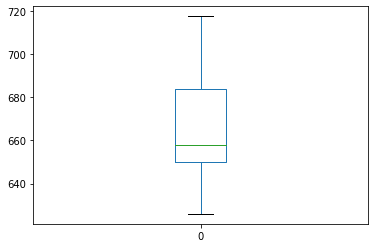

In [58]:
pd.DataFrame(cogs_forecasts).plot.box()